In [ ]:
#@title Installing HMM Learn
!pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
#@title Creation of a random sequence
import numpy as np

sequence = []

while len(sequence) < 400:
    numbers = np.random.permutation([1, 2, 3, 4, 5])
    for number in numbers:
        repetition = np.random.randint(1, 11)
        sequence.extend([number] * repetition)
    if len(sequence) >= 400:
        sequence = sequence[:400]
        break

print("Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:")
print(sequence)

Sequence of 400 numbers randomly picked from 1 to 5, repeating 1 to 10 times:
[3, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 4, 4, 4, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 5, 5, 5, 1, 

In [ ]:
#@title [other] dataset_extraction.py
import h5py
import numpy as np
import random

def training_dataset_OS_RGS_CBD(file_path, n_states, n_repeat_states, rat_indices_OS, rat_indices_RGS, rat_indices_CBD):
    """
    Extract a training dataset from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    n_states (int array): an array of 5 integers : [n_artefact, n_wake, n_nrem, n_TS, n_rem]. Each integer corresponds to the number of wanted epochs for the given state.
    n_repeat_states (int array): an array of 5 integers : [n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem].
                      Each integer corresponds to the number of times the epochs of the given state will be repeated in the training dataset.
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]

    Returns :
    float numpy.array : an array containing the features for each epoch of the training dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the training dataset.
    """
    n_artefact, n_wake, n_nrem, n_TS, n_rem = n_states
    n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem = n_repeat_states
    training_dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indices_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)
      for i in rat_indices_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)
        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

    selected_indices_artefact = random.sample(list(indices_artefact_total), n_artefact)
    selected_indices_wake = random.sample(list(indices_wake_total), n_wake)
    selected_indices_nrem = random.sample(list(indices_nrem_total), n_nrem)
    selected_indices_TS = random.sample(list(indices_TS_total), n_TS)
    selected_indices_rem = random.sample(list(indices_rem_total), n_rem)
    selected_indices_artefact = np.ravel([[el]* n_repeat_artefact for el in selected_indices_artefact])
    selected_indices_wake = np.ravel([[el]* n_repeat_wake for el in selected_indices_wake])
    selected_indices_nrem = np.ravel([[el]* n_repeat_nrem for el in selected_indices_nrem])
    selected_indices_TS = np.ravel([[el]* n_repeat_TS for el in selected_indices_TS])
    selected_indices_rem = np.ravel([[el]* n_repeat_rem for el in selected_indices_rem])

    features_artefact = array_features_total[selected_indices_artefact.astype(int)]
    scores = array_scores_total[selected_indices_artefact.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_artefact), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_wake = array_features_total[selected_indices_wake.astype(int)]
    scores = array_scores_total[selected_indices_wake.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_wake), axis=0)          # Filling up training dataset
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)                     # Filling up corresponding manual scores

    features_nrem = array_features_total[selected_indices_nrem.astype(int)]
    scores = array_scores_total[selected_indices_nrem.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_nrem), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_TS = array_features_total[selected_indices_TS.astype(int)]
    scores = array_scores_total[selected_indices_TS.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_TS), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    features_rem = array_features_total[selected_indices_rem.astype(int)]
    scores = array_scores_total[selected_indices_rem.astype(int)]
    training_dataset = np.concatenate((training_dataset, features_rem), axis=0)
    manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    paired = list(zip(training_dataset, manual_scoring))

    # Shuffle the paired list
    random.shuffle(paired)

    # Unzip the shuffled, paired list back into features and scores
    training_dataset, manual_scoring = zip(*paired)
    # training_dataset = np.array()
    training_dataset = np.array(training_dataset)
    manual_scoring = np.array(manual_scoring)

    return training_dataset, manual_scoring.astype(int)

def dataset_OS_RGS_CBD(file_path, rat_indices_OS, rat_indices_RGS, rat_indices_CBD, states):
    """
    Extract a dataset from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is not in a chronological order.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indices_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)

        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

      for i in rat_indices_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = np.concatenate((array_scores, group['Mapped_scores'][:]), axis = 0)
            array_features = np.concatenate((array_features, group['Features'][:]), axis = 0)
        indices_artefact = np.where(array_scores == 0)[0] # Artefact
        indices_wake = np.where(array_scores == 1)[0] # Wake
        indices_nrem = np.where(array_scores == 3)[0] # NREM
        indices_TS = np.where(array_scores  == 4)[0] #TS
        indices_rem = np.where(array_scores == 5)[0] # REM
        len_scores = len(array_scores_total)
        array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
        array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
        indices_artefact = np.array([el + len_scores for el in indices_artefact])
        indices_wake = np.array([el + len_scores for el in indices_wake])
        indices_nrem = np.array([el + len_scores for el in indices_nrem])
        indices_TS = np.array([el + len_scores for el in indices_TS])
        indices_rem = np.array([el + len_scores for el in indices_rem])
        indices_artefact_total = np.concatenate((indices_artefact_total, indices_artefact), axis = 0)
        indices_wake_total = np.concatenate((indices_wake_total, indices_wake), axis = 0)
        indices_nrem_total = np.concatenate((indices_nrem_total, indices_nrem), axis = 0)
        indices_TS_total = np.concatenate((indices_TS_total, indices_TS), axis = 0)
        indices_rem_total = np.concatenate((indices_rem_total, indices_rem), axis = 0)

    states = [el.lower() for el in states]

    if "artefact" in states:
      features_artefact = array_features_total[indices_artefact_total.astype(int)]
      scores = array_scores_total[indices_artefact_total.astype(int)]
      dataset = np.concatenate((dataset, features_artefact), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "wake" in states:
      features_wake = array_features_total[indices_wake_total.astype(int)]
      scores = array_scores_total[indices_wake_total.astype(int)]
      dataset = np.concatenate((dataset, features_wake), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "nrem" in states:
      features_nrem = array_features_total[indices_nrem_total.astype(int)]
      scores = array_scores_total[indices_nrem_total.astype(int)]
      dataset = np.concatenate((dataset, features_nrem), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "ts" in states:
      features_TS = array_features_total[indices_TS_total.astype(int)]
      scores = array_scores_total[indices_TS_total.astype(int)]
      dataset = np.concatenate((dataset, features_TS), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    if "rem" in states:
      features_rem = array_features_total[indices_rem_total.astype(int)]
      scores = array_scores_total[indices_rem_total.astype(int)]
      dataset = np.concatenate((dataset, features_rem), axis=0)
      manual_scoring = np.concatenate((manual_scoring, scores), axis=0)

    dataset = np.array(dataset)
    manual_scoring = np.array(manual_scoring)

    return dataset, manual_scoring.astype(int)

def dataset_in_order_OS_RGS_CBD(file_path, rat_indexes_OS, rat_indexes_RGS, rat_indexes_CBD, states):
    """
    Extract a dataset from the OS_RGS_CBD.h5 file while keeping the epochs in a chronolical order for each posttrial.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_indices_OS (int array): the indices of the rats from the OS_Basic dataset that would be included in the training dataset. #Included in [1, 3, 4, 6, 9, 11, 13]
    rat_indices_RGS (int array): the indices of the rats from the RGS14 dataset that would be included in the training dataset. #Included in [1, 2, 3, 4, 6, 7, 8, 9] (RGS control : [1, 2, 6, 9] and RGS positive : [3, 4, 7, 8])
    rat_indices_CBD (int array): the indices of the rats from the CBD dataset that would be included in the training dataset. #Included in [3, 4, 5, 6]
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is in a chronological order.
    If not all the states are included in the posttrial, this function will take a longer time than the dataset_OS_RGS_CBD function.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])
    states = [el.lower() for el in states]
    int_states = []
    if "artefact" in states:
      int_states.append(0)
    if "wake" in states:
      int_states.append(1)
    if "nrem" in states:
      int_states.append(3)
    if "ts" in states:
      int_states.append(4)
    if "rem" in states:
      int_states.append(5)

    array_scores_total = np.array([])
    array_features_total = np.empty((0, 10))
    indices_artefact_total = np.array([])
    indices_wake_total = np.array([])
    indices_nrem_total = np.array([])
    indices_TS_total = np.array([])
    indices_rem_total = np.array([])
    with h5py.File(file_path, 'r') as hdf:
      for i in rat_indexes_OS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["OS_basic"][f"Rat{i}"]:
            group = hdf["OS_basic"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

      for i in rat_indexes_RGS:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["RGS14"][f"Rat{i}"]:
            group = hdf["RGS14"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

      for i in rat_indexes_CBD:
        array_scores = np.array([])
        array_features = np.empty((0, 10))
        for group_name in hdf["CBD"][f"Rat{i}"]:
            group = hdf["CBD"][f"Rat{i}"][group_name]
            array_scores = group['Mapped_scores'][:]
            array_features = group['Features'][:]
            if int_states == [0, 1, 3, 4, 5]:
              array_features_total = np.concatenate((array_features_total, array_features), axis = 0)
              array_scores_total = np.concatenate((array_scores_total, array_scores), axis = 0)
            else:
              for j, el in enumerate(array_scores):
                  if el in int_states:
                    array_features_total = np.concatenate((array_features_total, [array_features[j]]), axis = 0)
                    array_scores_total = np.append(array_scores_total ,el)

    return array_features_total, array_scores_total.astype(int)

def posttrial_OS_RGS_CBD(file_path, rat_dataset, rat_index, posttrial_name, states):
    """
    Extract a posttrial from the OS_RGS_CBD.h5 file.

    Parameters :
    file_path (str): the file_path to the OS_RGS_CBD.h5 file
    rat_dataset (str) : the name of the rat dataset #"OS", "RGS" or"CBD"
    rat_index (int) : the index of the rat
    posttrial_name (str) : the name of the posttrial
    states : (str array) : an array containing the names of the states wanted in the dataset #Included in  ["artefact", "Wake", "NREM", "TS", "REM]

    Returns :
    float numpy.array : an array containing the features for each epoch of the dataset.
    int numpy.array : an array containing the manual sleep state scoring of each epoch of the dataset.

    Notes:
    The dataset obtained is in a chronological order.
    """
    dataset = np.empty((0, 10))
    manual_scoring = np.array([])

    states = [el.lower() for el in states]
    int_states = []
    if "artefact" in states:
      int_states.append(0)
    if "wake" in states:
      int_states.append(1)
    if "nrem" in states:
      int_states.append(3)
    if "ts" in states:
      int_states.append(4)
    if "rem" in states:
      int_states.append(5)

    with h5py.File(file_path, 'r') as hdf:
      if rat_dataset == "OS":
        group = hdf["OS_basic"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)


      elif rat_dataset == "RGS":
        group = hdf["RGS14"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)

      elif rat_dataset == "CBD":
        group = hdf["CBD"][f"Rat{rat_index}"][posttrial_name]
        array_scores = group['Mapped_scores'][:]
        array_features = group['Features'][:]
        if int_states == [0, 1, 3, 4, 5]:
              dataset = np.concatenate((dataset, array_features), axis = 0)
              manual_scoring = np.concatenate((manual_scoring, array_scores), axis = 0)
        else:
          for i, el in enumerate(array_scores):
              if el in int_states:
                dataset = np.concatenate((dataset, [array_features[i]]), axis = 0)
                manual_scoring = np.append(manual_scoring ,el)

    return dataset, manual_scoring.astype(int)

file_path='/content/drive/MyDrive/GitHubScripts/OS_RGS_CBD.h5'
n_states=[20, 20, 20, 20, 20] #[n_artefact, n_wake, n_nrem, n_TS, n_rem]
n_repeat_states=[1, 1, 1, 1, 1] #[n_repeat_artefact, n_repeat_wake, n_repeat_nrem, n_repeat_TS, n_repeat_rem]
rat_indices_OS=[1, 3, 4, 6, 9, 11, 13]
rat_indices_RGS=[1, 2, 3, 4, 6, 7, 8, 9]
rat_indices_CBD=[3, 4, 5, 6]
training_dataset_OS_RGS_CBD(file_path, n_states, n_repeat_states, rat_indices_OS, rat_indices_RGS, rat_indices_CBD)

(array([[0.88683702, 0.2105602 , 0.3495422 , 0.81398026, 0.54379409,
         0.39163381, 0.65423173, 0.08712996, 0.10702082, 0.08527484],
        [0.47776692, 0.69314344, 0.35296718, 0.69260015, 0.47902465,
         0.68228159, 0.35860236, 0.084668  , 0.47072836, 0.1095092 ],
        [0.22998774, 0.8729688 , 0.47506832, 0.48088908, 0.20226435,
         0.77813317, 0.13531824, 0.05      , 0.32545081, 0.05214682],
        [0.83000381, 0.30099817, 0.40315594, 0.67950666, 0.69890992,
         0.27142074, 0.75036198, 0.05272315, 0.07676727, 0.39223333],
        [0.10986578, 0.98810968, 0.1597533 , 0.57742527, 0.08881106,
         0.96304981, 0.05480897, 0.08106732, 0.79940744, 0.05779086],
        [0.47040929, 0.87476953, 0.05204727, 0.76137057, 0.41282808,
         0.90017445, 0.1726309 , 0.32062599, 0.4251506 , 0.05      ],
        [0.39330714, 0.90032872, 0.08496879, 0.75210684, 0.11778451,
         0.91735313, 0.11525804, 0.07023508, 0.59677182, 0.05      ],
        [0.29687222, 0.4745

In [ ]:
#@title HMM Code (Attempt 2)

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score

sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]

# the sequence is already created with the name : sequence
# Convert sequence to a numpy array and reshape for HMM
sequence = np.array(sequence).reshape(-1, 1)

n_hidden_states = 5

# Initialize and train the Gaussian HMM model
model = hmm.GaussianHMM(n_components=n_hidden_states, n_iter=100, tol=0.01, covariance_type="full")

# Fit the model to the original sequence
model.fit(sequence)

# Predict the sequence using the trained model
predicted_sequence = model.predict(sequence)

# Map predicted sequence back to original values
# HMM predicts states 0 through 4, map them back to 1 through 5
HMM_sequence = predicted_sequence + 1

# Post-process to reduce excessive consecutive repetitions predicted by the HMM
reduced_sequence = [HMM_sequence[0]]  # Start with the first element

# Iterate over predicted sequence and reduce unnecessary repetitions
for i in range(1, len(HMM_sequence)):
    if HMM_sequence[i] != HMM_sequence[i - 1]:
        reduced_sequence.append(HMM_sequence[i])

# Print first 50 elements for comparison
print("Original Sequence:", sequence.flatten())
print("HMM Sequence:", HMM_sequence)
print("Reduced Sequence:", reduced_sequence)
accuracy = accuracy_score(sequence, HMM_sequence)  # Compute accuracy
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

# Print the lengths of original and reduced sequences
print(f"Original sequence length: {len(sequence)}")
print(f"Reduced sequence length: {len(reduced_sequence)}")


Original Sequence: [1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3
 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5
 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3
 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5
 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5
 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2
 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5
 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5]
HMM Sequence: [3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 4 4 4 4 4 5 5
 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1
 1 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 4 4 4 4 4 5
 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1
 1 1 3 

In [ ]:
#@title HMM Code (Attempt 6)
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score

# Original sequence
sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
            5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
            4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
            3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1,
            2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
            1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
            5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
            4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
            3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1,
            2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]

while len(sequence) < 400:
    numbers = np.random.permutation([1, 2, 3, 4, 5])
    for number in numbers:
        repetition = np.random.randint(1, 11)
        sequence.extend([number] * repetition)
    if len(sequence) >= 400:
        sequence = sequence[:400]
        break

# Convert sequence to a numpy array and reshape for HMM
sequence = np.array(sequence).reshape(-1, 1)

n_hidden_states = 5  # Increase number of hidden states for better accuracy

# Initialize and train the Gaussian HMM model
model = hmm.GaussianHMM(n_components=n_hidden_states, n_iter=200, tol=0.01, covariance_type="full", random_state=42)

# Fit the model to the original sequence
model.fit(sequence)

# Predict the sequence using the trained model
predicted_sequence = model.predict(sequence)

# Map predicted sequence back to original values (ensure values are in range 1-5)
HMM_sequence = np.clip(predicted_sequence + 1, 1, 5).astype(int)

# Ensure the HMM sequence starts with the first value of the original sequence
HMM_sequence[0] = sequence[0, 0]


# Post-process to reduce excessive consecutive repetitions predicted by the HMM
reduced_sequence = [HMM_sequence[0]]  # Start with the first element

# Iterate over predicted sequence and reduce unnecessary repetitions
for i in range(1, len(HMM_sequence)):
    if HMM_sequence[i] != HMM_sequence[i - 1]:
        reduced_sequence.append(HMM_sequence[i])

# Print first 50 elements for comparison
print("Original Sequence:", sequence.flatten())
print("HMM Sequence:", HMM_sequence)
print("Reduced Sequence:", reduced_sequence)

# Calculate accuracy (Note: Original sequence must be reshaped)
accuracy = accuracy_score(sequence.flatten(), HMM_sequence)  # Compute accuracy
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

# Print the lengths of original and reduced sequences
print(f"Original sequence length: {len(sequence)}")
print(f"Reduced sequence length: {len(reduced_sequence)}")


Original Sequence: [2 2 2 2 2 2 2 2 2 4 4 5 5 5 5 1 1 1 1 1 1 1 3 4 4 4 4 4 4 4 4 4 4 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 5 5 5 5 5 5 1 1 1 1 1 1 4 4 4 4 5
 5 5 5 5 2 2 2 3 3 3 3 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 5 5 5 5 4 4 4
 4 4 4 4 4 4 3 3 3 3 3 3 3 4 4 4 1 1 1 1 1 1 2 2 2 2 5 5 5 5 5 5 5 3 3 3 4
 4 4 4 4 4 4 4 2 2 2 3 3 3 3 3 3 3 3 5 5 1 1 1 1 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 5 3
 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 1 1 1 5 5 5 5 5 5 4 4 4 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 4 3 3 3 3 3 3 3
 3 2 2 2 2 2 2 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 3 4 4 4 4 4 4 2 2 2 2 2 2 2 2
 2 2 5 5 5 5 5 1 3 3 4 4 4 4 2 4 4 4 3 3 3 3 3 1 1 1 5 5 5 5 5 1 1 1 1 1 1
 1 1 2 2 2 2 4 4 4 4 4 4 4 3 3 1 1 1 1 1 1 3 3 4 4 4 4 5 5 5]
HMM Sequence: [2 3 2 3 2 3 2 3 2 5 1 4 4 4 4 2 3 2 3 2 3 2 5 1 5 1 5 1 5 1 5 1 5 1 5 1 5
 1 5 1 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 3 4 4 4 4 4 4 2 3 2 3 3 2 5 1 5 1 4
 4 4 

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence (first 50): [3 5 3 3 3 1 3 5 4 4 4 2 1 2 2 4 5 5 1 2 2 3 2 2 5 2 4 4 2 5 3 1 1 4 3 3 1
 1 4 5 3 2 5 4 4 1 3 5 2 4]
Predicted Sequence (first 50): [3, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 1, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2, 5, 2, 2, 5, 1, 2, 5]
Prediction Accuracy: 19.25%


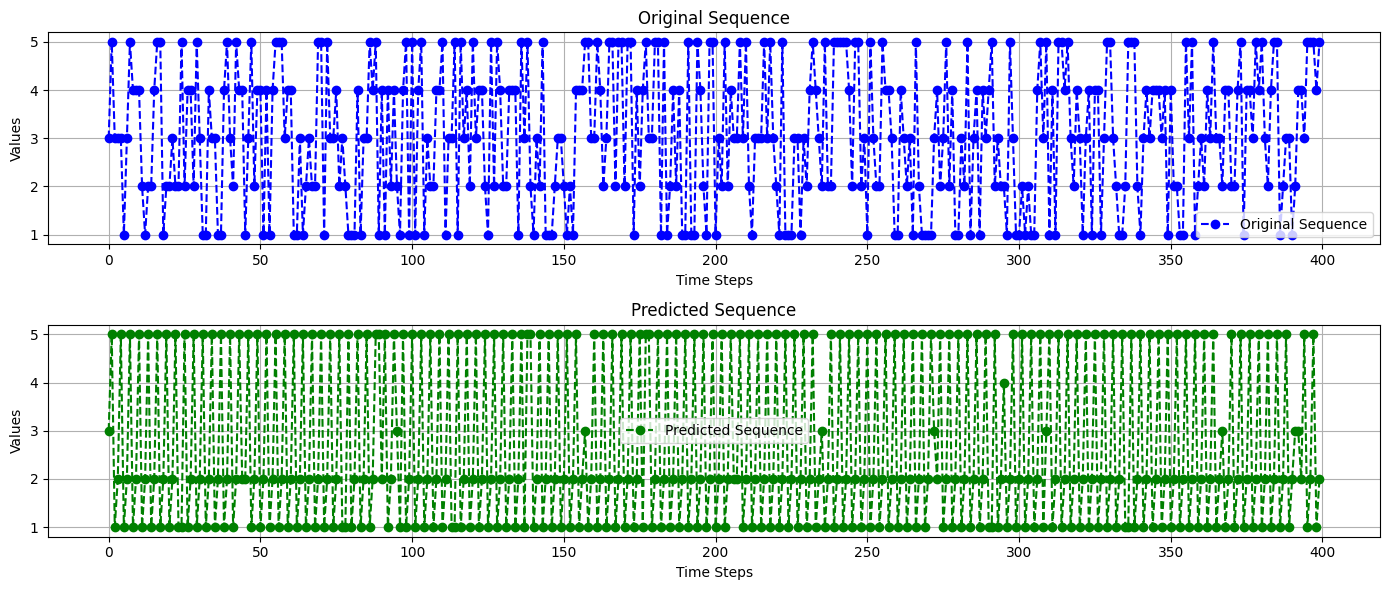

In [ ]:
#@title HMM Code (Attempt 7)
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define a more deterministic transition matrix (high probability of staying in the same state)
transition_matrix = np.array([
    [0.9, 0.1, 0.0, 0.0, 0.0],  # Hidden state 1 is likely to stay in state 1 or go to state 2
    [0.0, 0.9, 0.1, 0.0, 0.0],  # Hidden state 2 is likely to stay in state 2 or go to state 3
    [0.0, 0.0, 0.9, 0.1, 0.0],  # Hidden state 3 is likely to stay in state 3 or go to state 4
    [0.0, 0.0, 0.0, 0.9, 0.1],  # Hidden state 4 is likely to stay in state 4 or go to state 5
    [0.1, 0.0, 0.0, 0.0, 0.9]   # Hidden state 5 is likely to stay in state 5 or go to state 1
])

# Define a more deterministic emission matrix (each state strongly prefers a specific observable)
emission_matrix = np.array([
    [0.95, 0.02, 0.01, 0.01, 0.01],  # Hidden state 1 strongly emits 1
    [0.02, 0.95, 0.01, 0.01, 0.01],  # Hidden state 2 strongly emits 2
    [0.01, 0.01, 0.95, 0.02, 0.01],  # Hidden state 3 strongly emits 3
    [0.01, 0.01, 0.02, 0.95, 0.01],  # Hidden state 4 strongly emits 4
    [0.01, 0.01, 0.01, 0.01, 0.96]   # Hidden state 5 strongly emits 5
])

# Generate an original sequence based on hidden states and emission probabilities
n_hidden_states = 5
n_observations = 400
hidden_states = np.random.choice(n_hidden_states, size=n_observations, p=[0.2, 0.2, 0.2, 0.2, 0.2])

# Generate observed sequence based on hidden states and emission probabilities
observed_sequence = []
for state in hidden_states:
    observed = np.random.choice([1, 2, 3, 4, 5], p=emission_matrix[state])
    observed_sequence.append(observed)

# Convert observed sequence to array and reshape for fitting the model
observed_sequence = np.array(observed_sequence).reshape(-1, 1)

# Initialize the HMM model with multinomial distribution
model = hmm.MultinomialHMM(n_components=n_hidden_states, n_iter=100, tol=0.01, random_state=42)
model.startprob_ = np.array([1.0, 0.0, 0.0, 0.0, 0.0])  # Start from state 1
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# Fit the model to the observed sequence
model.fit(observed_sequence)

# Predict the hidden states from the observed sequence
predicted_hidden_states = model.predict(observed_sequence)

# Ensure that the first element of the predicted sequence matches the first element of the original sequence
predicted_hidden_states[0] = hidden_states[0]

# Re-generate the predicted sequence from the hidden states
predicted_sequence = []
for state in predicted_hidden_states:
    observed = np.random.choice([1, 2, 3, 4, 5], p=emission_matrix[state])
    predicted_sequence.append(observed)

# Ensure the first value of the predicted sequence matches the original sequence
predicted_sequence[0] = observed_sequence[0, 0]

# Compare the predicted sequence with the original sequence
accuracy = accuracy_score(observed_sequence.flatten(), predicted_sequence)

# Output results
print("Original Sequence (first 50):", observed_sequence.flatten()[:50])
print("Predicted Sequence (first 50):", predicted_sequence[:50])
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

# Plot the original sequence and the predicted sequence
plt.figure(figsize=(14, 6))

# Plot original sequence
plt.subplot(2, 1, 1)
plt.plot(observed_sequence.flatten(), label="Original Sequence", color='blue', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid(True)
plt.legend()

# Plot predicted sequence
plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, label="Predicted Sequence", color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


<ipython-input-19-a1837cbaae6c>:21: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True) # Normalize transition matrix so each row sums to 1
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 3 3 3 5 1 1 3 3 5 1 4 5 1 3 3 4 5 1 3 3 3 5 1 4 3 3 5 1 4 3 3 5 1 4 5 1
 3 3 3 5 1 1 3 3 5 4 5 1 3 3 3 4 5 1 4 3 3 5 1 4 3 3 5 1 3 3 3 5 1 3 3 5 1
 1 4 3 3 5 1 4 5 1 3 3 3 5 1 3 3 5]
Predicted Sequence: [2 1 2 3 4 5 1 2 3 4 5 1 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 4 5
 1 2 3 4 5 1 2 3 4 3 4 5 1 2 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 2 3 4 5
 5 1 2 3 4 5 1 4 5 1 2 3 4 5 2 3 4]
Accuracy: 17.58%


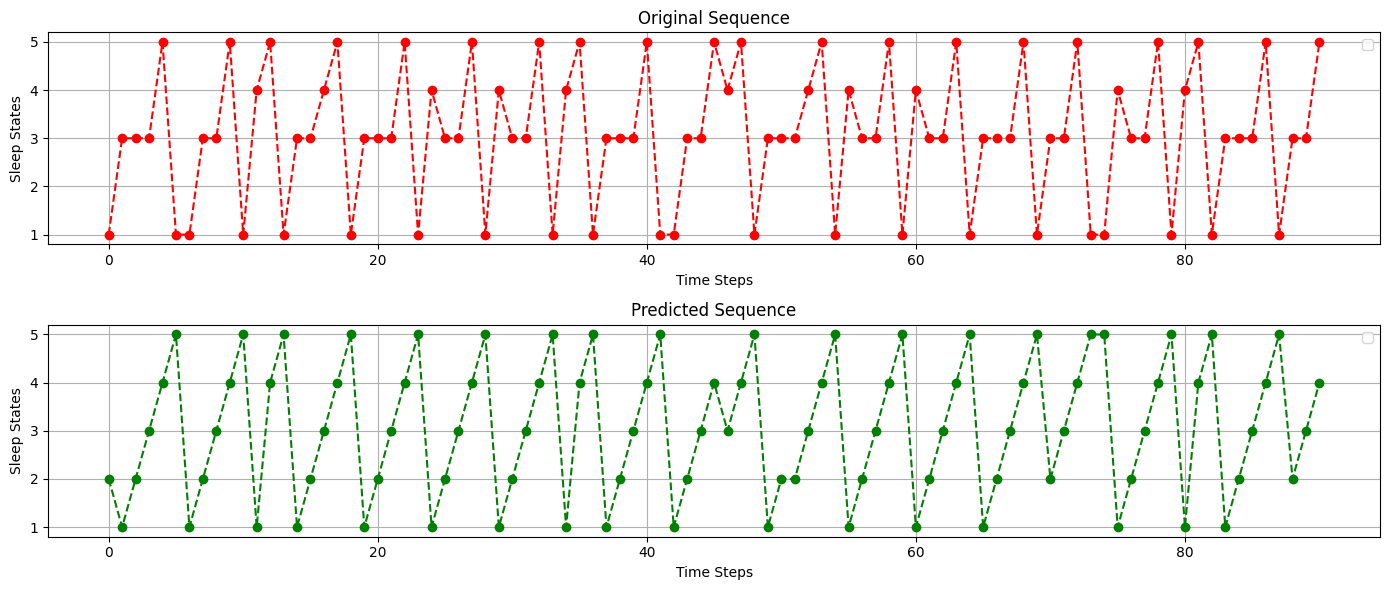

In [ ]:
# @title HMM Code (Friday 20-09-2024)
# install hmmlearn first time running on colab : (line below)
# !pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [1, 3, 3, 3, 5, 1, 1, 3, 3, 5, 1, 4, 5, 1, 3, 3, 4, 5, 1, 3, 3, 3, 5, 1, 4, 3, 3, 5, 1, 4, 3, 3, 5, 1, 4, 5, 1, 3, 3, 3, 5, 1, 1, 3, 3, 5, 4, 5, 1, 3, 3, 3, 4, 5, 1, 4, 3, 3, 5, 1, 4, 3, 3, 5, 1, 3, 3, 3, 5, 1, 3, 3, 5, 1, 1, 4, 3, 3, 5, 1, 4, 5, 1, 3, 3, 3, 5, 1, 3, 3, 5]

original_sequence = np.array(original_sequence)

#transition matrix
n_states = 5
transition_matrix = np.zeros((n_states, n_states))

for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True) # Normalize transition matrix so each row sums to 1

#emission matrix
emission_matrix = np.eye(n_states)

#hidden markov model
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # each observation is a single trial

observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int) # create the observed counts for HMM training

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01, random_state=42) # initialize the HMM model using the calculated transition and emission matrices

model.startprob_ = np.array([1] + [0] * (n_states - 1))  # start probabilities (start from state 1)

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix
model.n_trials = n_trials

model.fit(observed_counts) # fit the HMM model to the observed counts
predicted_sequence = model.predict(observed_counts)
predicted_sequence[0] = original_sequence[0] # ensure that the first element of the predicted sequence matches the first element of the original sequence
predicted_sequence = predicted_sequence + 1 # adjust the predicted sequence values to match the original value range (1 to 5)

# OUTPUTS :
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")


# FIGURES :
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [1 2 2 3 3 3 3 3 3 4 4 5 5 1 2 2 2 3 3 3 3 3 3 4 4 4 5 5 5 1 2 3 3 3 3 4 4
 5 1 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 5 5 5 5 1 2 2 3 3 3 3 3 4 4 5 5 5 5 1 2

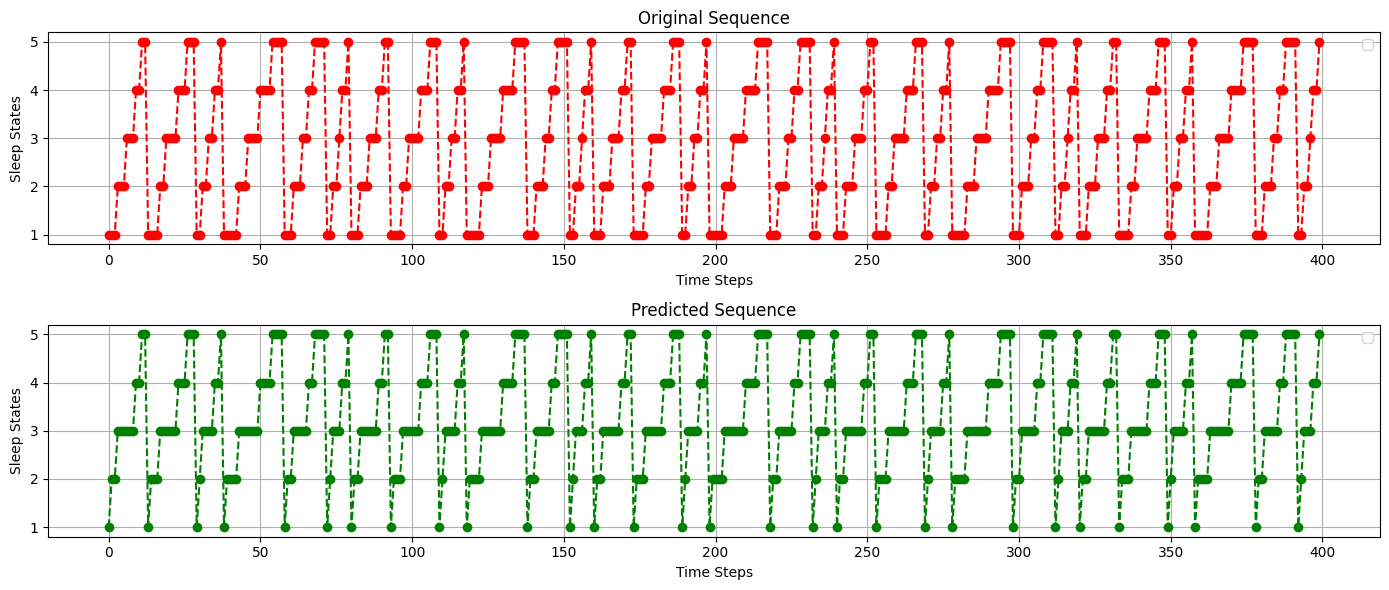

In [ ]:
# @title HMM Code (Wednesday 26-09-2024)

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)
!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

#Transition matrix
n_states = 5
transition_matrix = np.zeros((n_states, n_states))

for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)  # Normalize transition matrix

#Emission matrix
emission_matrix = np.eye(n_states)

#HMM
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # each observation is a single trial

observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)  # create observed counts for HMM

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

#Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=0.01, random_state=42)
start_state = original_sequence[0] - 1  # Convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # Set 100% start probability at the initial state of the original sequence

model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix
model.n_trials = n_trials

#Fit the model to the observed counts
model.fit(observed_counts)

#Predict the sequence
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

#Accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

#figures
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4
 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1
 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1
 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4
 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2 3 3 3 3 4 4
 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 1 1 1 2
 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5 1 1 1 1 2 2
 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3 4 4 4 4 5 5
 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5 1 1 1 2 2 2 3 3 3 4 4 5 5
 1 1 1 1 2 2 3 3 3 3 4 4 4 5 5 5 1 1 2 2 3 3 4 4 5 1 1 1 1 1 2 2 2 3 3 3 3
 4 4 4 4 5 5 5 5 1 1 1 2 2 2 3 3 4 4 5 5 5 5 1 1 2 2 3 4 4 5]
Predicted Sequence: [4 5 3 3 3 3 3 3 3 4 4 2 2 2 2 1 5 3 3 3 3 3 3 4 4 4 2 2 2 1 5 3 3 3 3 4 4
 2 2 2 2 1 5 3 3 3 3 3 3 3 4 4 4 4 2 2 2 2 2 1 5 3 3 3 3 3 4 4 2 2 2 2 1 5

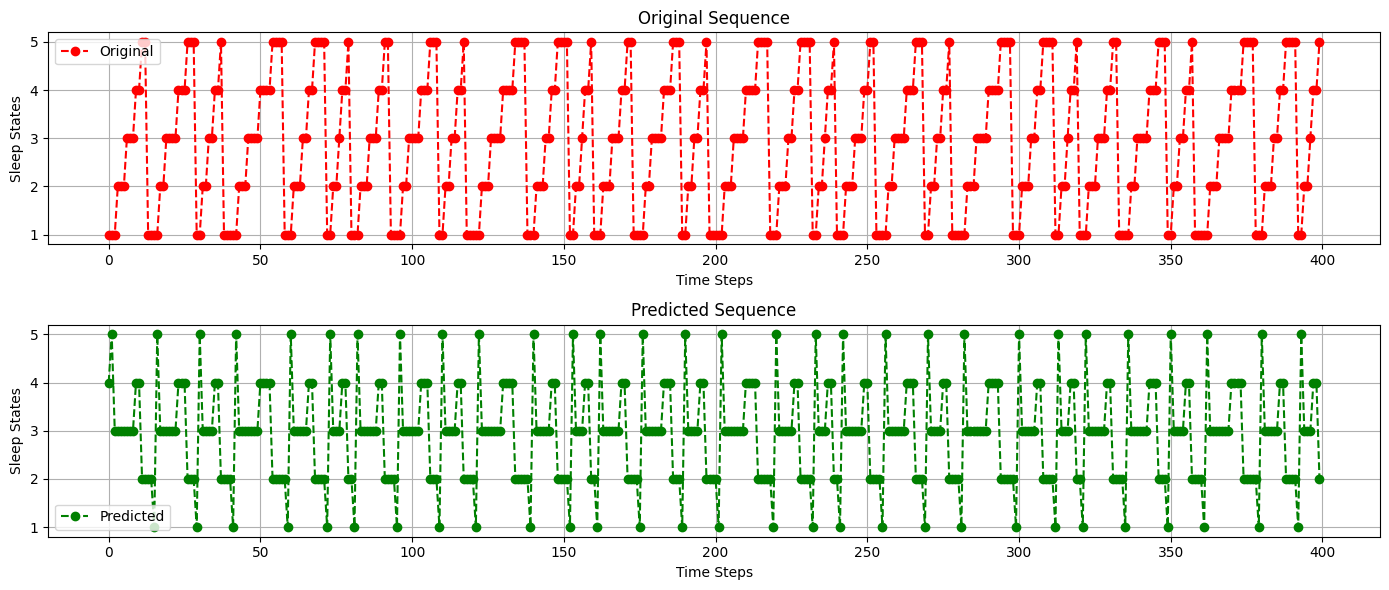

In [17]:
# @title HMM Code (Friday 27-09-2024)

# This program uses a random sequence

# install hmmlearn first time running on colab : (line below)

!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Original sequence with a repeating pattern
original_sequence = [
    1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
    4, 5, 5, 1, 1, 1, 1, 2, 2, 3,
    3, 3, 3, 4, 4, 4, 5, 5, 5, 1,
    1, 2, 2, 3, 3, 4, 4, 5, 1, 1,
    1, 1, 1, 2, 2, 2, 3, 3, 3, 3,
    4, 4, 4, 4, 5, 5, 5, 5, 1, 1,
    1, 2, 2, 2, 3, 3, 4, 4, 5, 5,
    5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5  # 400 numbers in total following a certain pattern

original_sequence = np.array(original_sequence)

n_states = 5

# HMM - Preprocessing the observed sequence
observed_sequence = (original_sequence - 1).reshape(-1, 1)  # Convert to 0-based indexing

n_trials = np.ones(observed_sequence.shape[0])  # Each observation is a single trial

# Create observed counts for the HMM
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)

for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1  # Set the count for the observed value

# Initialize the HMM model
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42)

# Number of iterations to refine the model
iterations = 5

# Train the model iteratively
for _ in range(iterations):
    model.fit(observed_counts)

# Predict the sequence using the trained model
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

# Calculate accuracy
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Original'])

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)
plt.legend(['Predicted'])

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3
 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5
 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3
 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5
 5 5 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5]
Predicted Sequence: [1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 4 4 4 4 4 5 5 5 5
 5 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 4 4 4 4 4 5 5 5
 5 5 1 1 1 1 1 1 1 1 1 1 2 2 2 2 3 4 4 4 4 4 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 3 4 4 4 4 4 5 5 5 5 5]
Accuracy: 64.00%


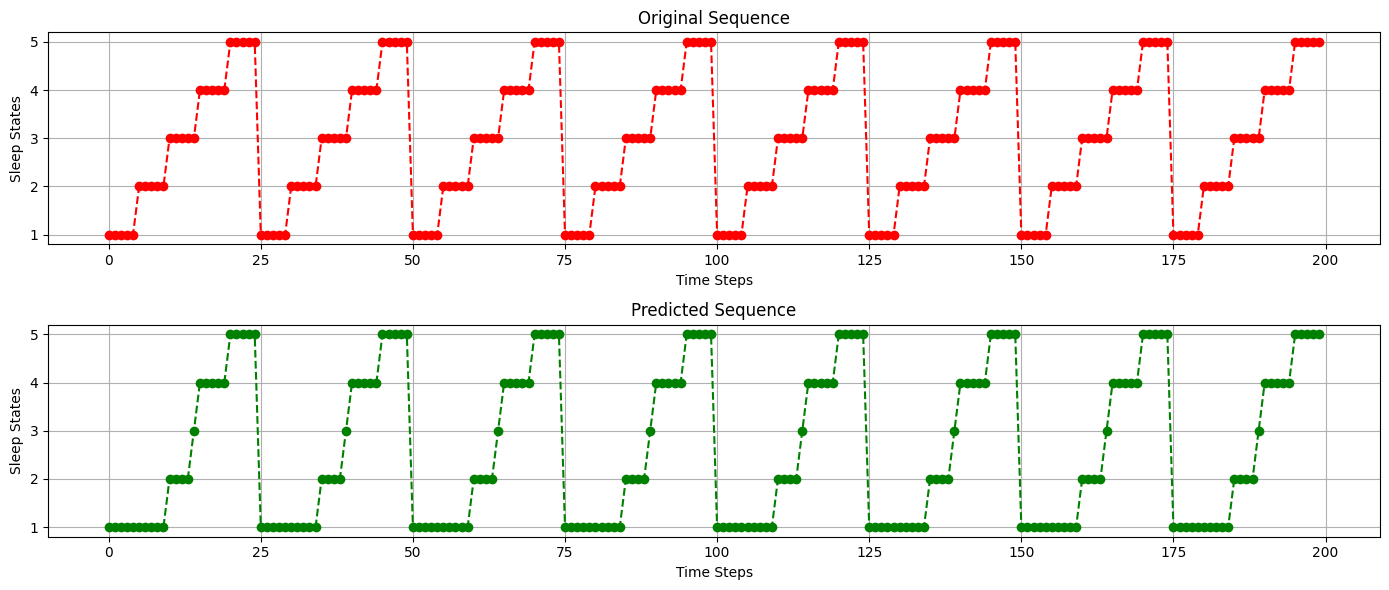

In [41]:
# @title HMM Code (Monday 30-09-2024) - learning/predicting
# This program uses a random sequence with a somehow repeating pattern

# install hmmlearn first time running on colab : (line below)
!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# SEQUENCES
#original_sequence = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5
original_sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5]
#original_sequence = [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 3, 3, 5, 5, 5, 3, 2, 2, 1, 1, 2, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 5, 3, 2, 1, 1, 2, 3, 3, 4, 3, 3, 5, 5, 5, 5, 3, 2, 1, 2, 3, 3, 3, 5, 5, 5, 5, 2, 1, 1, 2, 3, 5, 5, 5, 5, 3, 2, 1, 1, 1, 1] * 3

original_sequence = np.array(original_sequence)
n_states = 5

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True) # normalization of the transition matrix (row-wise)

# EMISSION MATRIX
emission_matrix = np.eye(n_states)

# Preprocess the observed sequence: convert to 0-based indexing
observed_sequence = (original_sequence - 1).reshape(-1, 1)

# Set up observed counts for HMM (one-hot encoded observations)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# Initialize the HMM model with init_params='e' to keep the manual transition and start probabilities
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='e')

# START PROBABILITIES
start_state = original_sequence[0] - 1  # Convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # Set 100% start probability for the initial state of the original sequence

# TRANS & EMISSION MATRIXES
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING
iterations = 200
for _ in range(iterations):
    model.fit(observed_counts)

# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # Adjust back to 1-based indexing

# ACCURACY (%)
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# FIGURES
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.tight_layout()
plt.show()


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Original Sequence: [3 2 2 5 5 5 5 4 4 4 4 1 4 4 4 4 4 1 2 2 2 2 2 2 2 2 2 2 4 4 1 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3
 3 3 3 3 5 5 5 2 2 2 2 2 2 1 1 1 1 4 5 5 5 5 5 3 3 3 3 3 3 3 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 3 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 2 2 1 1 1 1 3 3 3 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4
 2 2 2 2 2 2 2 2 2 1 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 1 1 1 5 2 2 2 2 2 2 2 2
 2 4 4 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 2 2 2 4 4 4 4 4
 4 4 4 4 4 2 2 2 2 1 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 3 3 3 3 1 3 3 3 3 3 3 3
 4 4 4 4 2 2 2 2 2 5 5 5 5 5 3 3 3 3 3 1 1 1 1 1 1 1 1 4 4 4]
Predicted Sequence: [3 2 2 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 4 3 3 3 3 3 5
 5 5 2 2 4 4 4 4 5 5 5 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 2

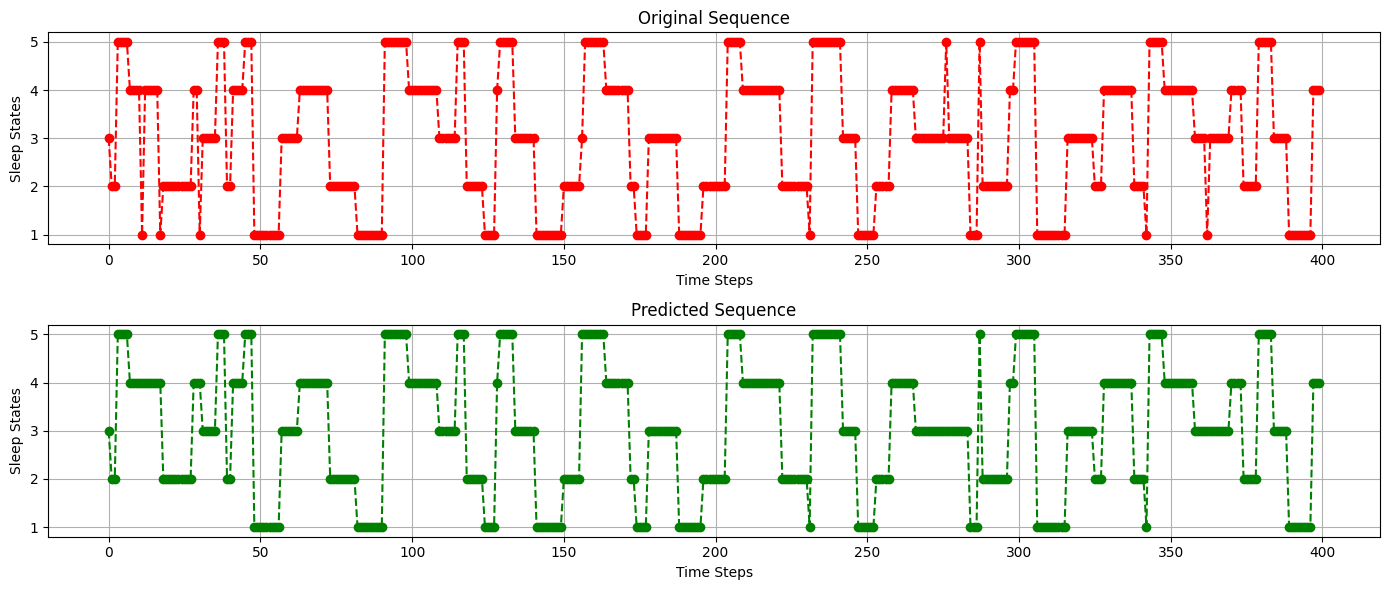

In [40]:
# @title HMM Code (Monday 30-09-2024) - Perfect replication
# install hmmlearn first time running on colab : (line below)

#!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#original_sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5] * 5  # Example long sequence
#original_sequence = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 1, 1, 2, 2, 3, 3, 4, 4, 5, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 1, 1, 2, 2, 3, 4, 4, 5] * 5
#original_sequence = [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 3, 3, 5, 5, 5, 3, 2, 2, 1, 1, 2, 3, 3, 4, 4, 4, 4, 3, 3, 5, 5, 5, 3, 2, 1, 1, 2, 3, 3, 4, 3, 3, 5, 5, 5, 5, 3, 2, 1, 2, 3, 3, 3, 5, 5, 5, 5, 2, 1, 1, 2, 3, 5, 5, 5, 5, 3, 2, 1, 1, 1, 1] * 3
original_sequence = [3, 2, 2, 5, 5, 5, 5, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 4, 4, 4, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 5, 5, 5, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4]

original_sequence = np.array(original_sequence)
n_states = 5  # hidden states

# TRANSITION MATRIX
transition_matrix = np.zeros((n_states, n_states))
for (current_state, next_state) in zip(original_sequence[:-1], original_sequence[1:]):
    transition_matrix[current_state - 1, next_state - 1] += 1
transition_matrix = (transition_matrix + 0.01)  # add small smoothing value to avoid zero probabilities
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)  # normalize row-wise

# EMISSION MATRIX (slightly noisy diagonal)
emission_matrix = np.eye(n_states) * 0.9 + 0.1 / n_states

# Convert observed sequence to 0-based indexing & set up observed counts for HMM (one-hot encoded observations)
observed_sequence = (original_sequence - 1).reshape(-1, 1)
observed_counts = np.zeros((observed_sequence.shape[0], n_states), dtype=int)
for i in range(observed_sequence.shape[0]):
    observed_counts[i, observed_sequence[i, 0]] = 1

# HMM MODEL
model = hmm.MultinomialHMM(n_components=n_states, n_iter=1, tol=0.01, random_state=42, init_params='')
start_state = original_sequence[0] - 1  # convert to 0-based index
model.startprob_ = np.zeros(n_states)
model.startprob_[start_state] = 1  # start with the same state as original sequence
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# TRAINING
iterations = 10
for _ in range(iterations):
    model.fit(observed_counts)

# PREDICTED SEQUENCE
predicted_sequence = model.predict(observed_counts)
predicted_sequence = predicted_sequence + 1  # adjust back to 1-based indexing

# ACCURACY (%)
accuracy = accuracy_score(original_sequence, predicted_sequence)
print(f"Original Sequence: {original_sequence}")
print(f"Predicted Sequence: {predicted_sequence}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# FIGURES
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(original_sequence, color='red', marker='o', linestyle='dashed')
plt.title("Original Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(predicted_sequence, color='green', marker='o', linestyle='dashed')
plt.title("Predicted Sequence")
plt.xlabel("Time Steps")
plt.ylabel("Sleep States")
plt.grid(True)

plt.tight_layout()
plt.show()
